In [ ]:
import os
from dotenv import load_dotenv

os.environ["USER_AGENT"] = "AnalystChain/1.0 (Python Analysis Tool)"
load_dotenv("../config/.env")

True

In [4]:
import bs4
from typing_extensions import TypedDict, List
from langchain import hub
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import StateGraph, START
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
vector_store = InMemoryVectorStore(embeddings)
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    )
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieve_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieve_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
response = graph.invoke({"question": "什么是任务拆分？"})

print(response["answer"])

USER_AGENT environment variable not set, consider setting it to identify your requests.


任务拆分是指将一个复杂任务分解成多个较小、更易管理的子任务的过程。根据上下文，它可以由大型语言模型通过简单提示完成，或依赖外部规划器（如LLM+P）进行处理。这种方法有助于理清任务间的逻辑关系和依赖顺序。


In [7]:
for step in graph.stream(
    {"question": "什么是任务拆分？"},
    stream_mode="updates",
):
    print(f"f{step}\n---------------\n")

f{'retrieve': {'context': [Document(id='2be4484f-4507-482c-8e8a-b13758c176b2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resourc

In [11]:
for message, _ in graph.stream(
    {"question": "什么是任务拆分？"},
    stream_mode="messages",
):
    print(message.content, end="|")

|任务|拆分|是指|将|一项|复杂|任务|分解|成|多个|较小|、|更|易|管理的|子|任务|的过程|。|根据|上下文|，|它可以|由|大型|语言|模型|通过|简单|提示|完成|，|或|依赖|外部|规划|器|（|如|LL|M|+P|方法|）|进行处理|。|这种方法|有助于|理|清|任务|间的|逻辑|关系和|依赖|顺序|。||

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


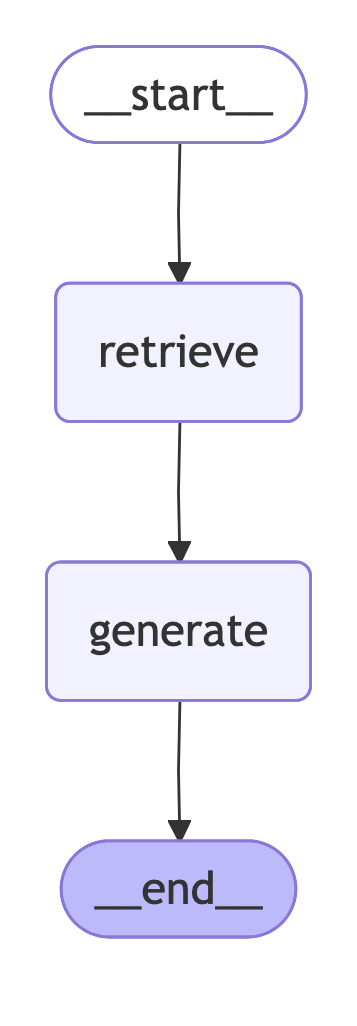

In [10]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# 允许嵌套事件循环
nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))